In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('../data/clean_data.csv', index_col=0)
df.head()

,airline_sentiment,negativereason,airline,retweet_count,text,text_clean
0,positive,No Reason,Virgin America,0,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
1,negative,Bad Flight,Virgin America,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
2,negative,Can't Tell,Virgin America,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
3,negative,Can't Tell,Virgin America,0,@VirginAmerica seriously would pay $30 a fligh...,seriously pay flight seat did playing really b...
4,positive,No Reason,Virgin America,0,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly time fly vx ear worm away


In [3]:
#Create new column where positive sentiment is 0, negative sentiment is 1
df['sentiment_num'] = df.airline_sentiment.map({'positive':1, 'negative':0})
df.head()

,airline_sentiment,negativereason,airline,retweet_count,text,text_clean,sentiment_num
0,positive,No Reason,Virgin America,0,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky,1
1,negative,Bad Flight,Virgin America,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,0
2,negative,Can't Tell,Virgin America,0,@VirginAmerica and it's a really big bad thing...,really big bad thing,0
3,negative,Can't Tell,Virgin America,0,@VirginAmerica seriously would pay $30 a fligh...,seriously pay flight seat did playing really b...,0
4,positive,No Reason,Virgin America,0,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly time fly vx ear worm away,1


## Splitting Train and Test Sets

In [4]:
#Create features set (just text) and target set (just sentiment number)
X = df.text_clean
y = df.sentiment_num
print(X.shape)
print(y.shape)

(11523,)
(11523,)


In [5]:
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8066,)
(3457,)
(8066,)
(3457,)


## Vectorizing And Training

### Defining Pipelines

To decide on best vectorizer and classifier combination, we will define a few pipelines and use GridSearchCV to find the optimal hyperparameters. We will use accuracy as our scoring parameter for each model. 

In [6]:
#Initialize vectorizers and classifiers
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer()
lr = LogisticRegression()
nb = MultinomialNB()
svc = SVC()

#Define each pipeline for each combination of vect and clf
pipline_cv_lr = Pipeline([
    ('vectorizer', count_vect),
    ('classifier', lr)
])

pipline_cv_nb = Pipeline([
    ('vectorizer', count_vect),
    ('classifier', nb)
])

pipline_cv_svc = Pipeline([
    ('vectorizer', count_vect),
    ('classifier', svc)
])

pipline_tf_lr = Pipeline([
    ('vectorizer', tfidf_vect),
    ('classifier', lr)
])

pipline_tf_nb = Pipeline([
    ('vectorizer', tfidf_vect),
    ('classifier', nb)
])

pipline_tf_svc = Pipeline([
    ('vectorizer', tfidf_vect),
    ('classifier', svc)
])

#Define paramters for each pipeline
params_lr = {
    'vectorizer__min_df': [3,5,10],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_df': [0.75, 1.0],
    'classifier__C': [0.1, 1, 10],
    'classifier__max_iter': [1000]
}

params_nb = {
    'vectorizer__min_df': [3,5,10,50],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'vectorizer__max_df': [0.5, 0.75, 1.0],
    'classifier__alpha': [0.1, 1, 10]
}

params_svc = {
    'vectorizer__min_df': [3,5,10],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_df': [0.5, 0.75, 1.0],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__probability': [True]
}

In [7]:
#Initialize each gridsearchcv object
grid_cv_lr = GridSearchCV(pipline_cv_lr, params_lr, scoring='roc_auc', cv=3)
grid_cv_nb = GridSearchCV(pipline_cv_nb, params_nb, scoring='roc_auc', cv=3)
grid_cv_svc = GridSearchCV(pipline_cv_svc, params_svc, scoring='roc_auc', cv=3)
grid_tf_lr = GridSearchCV(pipline_tf_lr, params_lr, scoring='roc_auc', cv=3)
grid_tf_nb = GridSearchCV(pipline_tf_nb, params_nb, scoring='roc_auc', cv=3)
grid_tf_svc = GridSearchCV(pipline_tf_svc, params_svc, scoring='roc_auc', cv=3)

#### CountVectorizer & Logistic Regression Performance

In [8]:
grid_cv_lr.fit(X_train, y_train)

print('CountVectorizer & Logistic Regression CV Performance')
print('Best parameters: ', grid_cv_lr.best_params_)
print('Best score: ', grid_cv_lr.best_score_ ) 

CountVectorizer & Logistic Regression CV Performance
Best parameters:  {'classifier__C': 1, 'classifier__max_iter': 1000, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.9378268998644176


In [9]:
vect1 = CountVectorizer(max_df = grid_cv_lr.best_params_['vectorizer__max_df'], 
                        min_df = grid_cv_lr.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_cv_lr.best_params_['vectorizer__ngram_range'])
X_train_dtm1 = vect1.fit_transform(X_train)
X_test_dtm1 = vect1.transform(X_test)

lr1 = LogisticRegression(C = grid_cv_lr.best_params_['classifier__C'], max_iter = 1000)
lr1.fit(X_train_dtm1, y_train)
metrics.roc_auc_score(y_test, lr1.predict_proba(X_test_dtm1)[:,1])

0.9478840169731259

#### CountVectorizer & Multinomial Naive Bayes Performance

In [10]:
grid_cv_nb.fit(X_train, y_train)

print('CountVectorizer & Multinomial Naive Bayes CV Performance')
print('Best parameters: ', grid_cv_nb.best_params_)
print('Best score: ', grid_cv_nb.best_score_ ) 

CountVectorizer & Multinomial Naive Bayes CV Performance
Best parameters:  {'classifier__alpha': 1, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.9363682365688671


In [11]:
vect2 = CountVectorizer(max_df = grid_cv_nb.best_params_['vectorizer__max_df'], 
                        min_df = grid_cv_nb.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_cv_nb.best_params_['vectorizer__ngram_range'])
X_train_dtm2 = vect2.fit_transform(X_train)
X_test_dtm2 = vect2.transform(X_test)

nb1 = MultinomialNB(alpha = grid_cv_nb.best_params_['classifier__alpha'])
nb1.fit(X_train_dtm2, y_train)
metrics.roc_auc_score(y_test, nb1.predict_proba(X_test_dtm2)[:,1])

0.938934807766491

#### CountVectorizer & Support Vector Classifier Performance

In [12]:
grid_cv_svc.fit(X_train, y_train)

print('CountVectorizer & Support Vector Classifier CV Performance')
print('Best parameters: ', grid_cv_svc.best_params_)
print('Best score: ', grid_cv_svc.best_score_ ) 

CountVectorizer & Support Vector Classifier CV Performance
Best parameters:  {'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'classifier__probability': True, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.9303587782383946


In [13]:
vect3 = CountVectorizer(max_df = grid_cv_svc.best_params_['vectorizer__max_df'], 
                        min_df = grid_cv_svc.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_cv_svc.best_params_['vectorizer__ngram_range'])
X_train_dtm3 = vect3.fit_transform(X_train)
X_test_dtm3 = vect3.transform(X_test)

svc1 = SVC(kernel = grid_cv_svc.best_params_['classifier__kernel'], gamma = grid_cv_svc.best_params_['classifier__gamma'])
svc1.fit(X_train_dtm3, y_train)
metrics.roc_auc_score(y_test, svc1.predict(X_test_dtm3))

0.7853732801851614

#### TfidfVectorizer & Logistic Regression Performance

In [14]:
grid_tf_lr.fit(X_train, y_train)

print('TfidfVectorizer & Logistic Regression CV Performance')
print('Best parameters: ', grid_tf_lr.best_params_)
print('Best score: ', grid_tf_lr.best_score_ ) 

TfidfVectorizer & Logistic Regression CV Performance
Best parameters:  {'classifier__C': 1, 'classifier__max_iter': 1000, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.9390340293926768


In [15]:
vect4 = TfidfVectorizer(max_df = grid_tf_lr.best_params_['vectorizer__max_df'], 
                        min_df = grid_tf_lr.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_tf_lr.best_params_['vectorizer__ngram_range'])
X_train_dtm4 = vect4.fit_transform(X_train)
X_test_dtm4 = vect4.transform(X_test)

lr2 = LogisticRegression(C = grid_tf_lr.best_params_['classifier__C'], max_iter = 1000)
lr2.fit(X_train_dtm4, y_train)
metrics.roc_auc_score(y_test, lr2.predict_proba(X_test_dtm4)[:,1])

0.9470981098109811

#### TfidfVectorizer & Multinomial Naive Bayes Performance

In [16]:
grid_tf_nb.fit(X_train, y_train)

print('TfidfVectorizer & Multinomial Naive Bayes CV Performance')
print('Best parameters: ', grid_tf_nb.best_params_)
print('Best score: ', grid_tf_nb.best_score_ )

TfidfVectorizer & Multinomial Naive Bayes CV Performance
Best parameters:  {'classifier__alpha': 0.1, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.9333647042362374


In [17]:
vect5 = TfidfVectorizer(max_df = grid_tf_nb.best_params_['vectorizer__max_df'], 
                        min_df = grid_tf_nb.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_tf_nb.best_params_['vectorizer__ngram_range'])
X_train_dtm5 = vect5.fit_transform(X_train)
X_test_dtm5 = vect5.transform(X_test)

nb2 = MultinomialNB(alpha = grid_tf_nb.best_params_['classifier__alpha'])
nb2.fit(X_train_dtm5, y_train)
metrics.roc_auc_score(y_test, nb2.predict_proba(X_test_dtm5)[:,1])

0.9374239423942393

#### TfidfVectorizer & Support Vector Classifier Performance

In [18]:
grid_tf_svc.fit(X_train, y_train)

print('TfidfVectorizer & Support Vector Classifier CV Performance')
print('Best parameters: ', grid_tf_svc.best_params_)
print('Best score: ', grid_tf_svc.best_score_ )

TfidfVectorizer & Support Vector Classifier CV Performance
Best parameters:  {'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'classifier__probability': True, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 1)}
Best score:  0.9365146164457628


In [19]:
vect6 = TfidfVectorizer(max_df = grid_tf_svc.best_params_['vectorizer__max_df'], 
                        min_df = grid_tf_svc.best_params_['vectorizer__min_df'], 
                        ngram_range = grid_tf_svc.best_params_['vectorizer__ngram_range'])
X_train_dtm6 = vect6.fit_transform(X_train)
X_test_dtm6 = vect6.transform(X_test)

svc2 = SVC(kernel = grid_cv_svc.best_params_['classifier__kernel'], gamma = grid_cv_svc.best_params_['classifier__gamma'])
svc2.fit(X_train_dtm6, y_train)
metrics.roc_auc_score(y_test, svc2.predict(X_test_dtm6))

0.7977796065320817

### Evaluating the Best Model

We can see that the CountVectorizer and Logistic Regression had the best roc auc score on the test set. Let's use this as our final model and look further at the performance of this model. 

In [20]:
#Redefine names of vectorizers, sets, and model for ease of further evaluation
vect = CountVectorizer(max_df = grid_cv_lr.best_params_['vectorizer__max_df'], 
                       min_df = grid_cv_lr.best_params_['vectorizer__min_df'], 
                       ngram_range = grid_cv_lr.best_params_['vectorizer__ngram_range'])
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

lr = LogisticRegression(C = grid_cv_lr.best_params_['classifier__C'], max_iter = 1000)
lr.fit(X_train_dtm, y_train)
y_pred_train = lr.predict_proba(X_train_dtm)[:,1]
y_pred_test = lr.predict_proba(X_test_dtm)[:,1]

In [21]:
#Look at the train set as a pandas Dataframe
pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())

,aa,abc,ability,able,abq,absolute,absolutely,absurd,abysmal,ac,...,york,young,yous,yr,yuma,yup,yyz,zero,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
type(X_train_dtm)

scipy.sparse.csr.csr_matrix

We can see this a sparse matrix (lots of zeros). We can also see that a lot of these words are nonsensical, probably typos, etc. but they may create noise in our model. We will attempt later on to find only the most important words and use those as our feature set. First, lets see how a prediction model works on this feature set. 

In [23]:
print ("Accuracy on training data:   %0.3f" % (lr.score(X_train_dtm, y_train)))
print ("Accuracy on test data:       %0.3f" % (lr.score(X_test_dtm, y_test)))
print ("ROC AUC Score on train data: %0.3f" % (metrics.roc_auc_score(y_train, y_pred_train)))
print ("ROC AUC Score on test data:  %0.3f" % (metrics.roc_auc_score(y_test, y_pred_test)))

Accuracy on training data:   0.948
Accuracy on test data:       0.906
ROC AUC Score on train data: 0.986
ROC AUC Score on test data:  0.948


We can see that this model performs quite well. It also does not seem to be overfitting the training data as the accuracy on the test data looks good as well. 

Let's now find the find the optimal threshold for the model to make it even better. To do so, we will be taking a look at precision, recall, and f1 score across all thresholds. 

In [24]:
#Defining a function that returns precision recall and f_beta score
#We will plot them against different thresholds

def precision_recall(model, X_test, y_test, threshold, beta = 1):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    matrix = metrics.confusion_matrix(y_test, y_pred)
    
    #print(threshold,'\n', matrix)
    
    tn = matrix[0,0] # tweets predicted to be negative and were negative
    tp = matrix[1,1] # tweets predicted to be positive and were positive
    fp = matrix[0,1] # tweets predicted to be positive and were negative
    fn = matrix[1,0] # tweets predicted to be negative and were positive
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    #fdr = fp/(fp+tp)
    f_beta = metrics.fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, f_beta])

In [25]:
threshold_df_alc = pd.DataFrame(columns=['Precision','Recall', 'F1 Score'])

for threshold in sorted(set(lr.predict_proba(X_test_dtm)[:,1])):
    threshold_df_alc.loc[threshold] = precision_recall(lr, X_test_dtm, y_test, threshold)

Text(0.4, 0.55, 'Optimal Threshold')

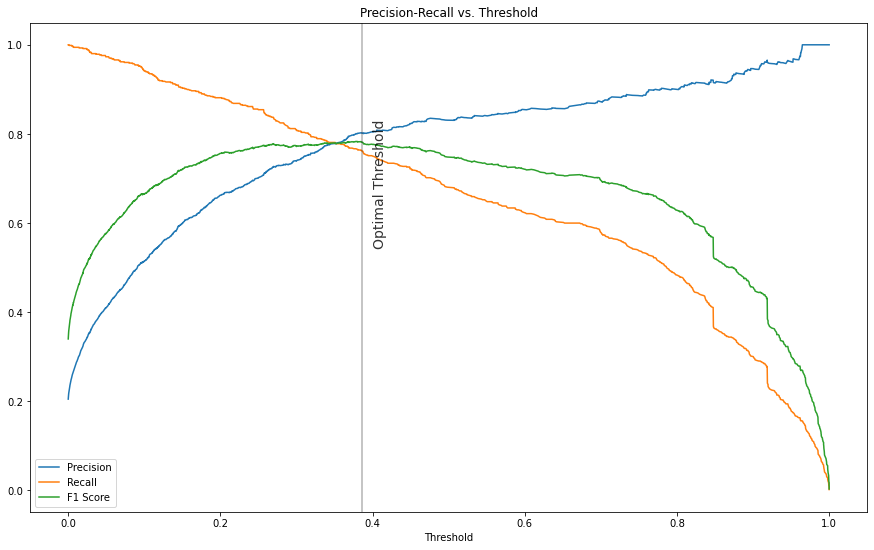

In [26]:
ax = threshold_df_alc.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Threshold')
ax.axvline(0.386, color='black', alpha=0.3)
ax.text(.4,.55,'Optimal Threshold',rotation=90, alpha=0.8, fontsize=14)

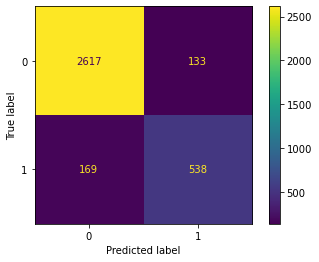

In [27]:
#Let's look at the confusion matrix for the test
cm = metrics.confusion_matrix(y_test, lr.predict_proba(X_test_dtm)[:,1] > 0.386)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [28]:
print(metrics.classification_report(y_test, lr.predict_proba(X_test_dtm)[:,1] > 0.386))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2750
           1       0.80      0.76      0.78       707

    accuracy                           0.91      3457
   macro avg       0.87      0.86      0.86      3457
weighted avg       0.91      0.91      0.91      3457



In [29]:
# print message text for the false positives (negative tweets incorrectly labeled as positive)
y_positive = lr.predict_proba(X_test_dtm)[:,1] > 0.386
X_test[y_test < y_positive.astype(int)].head(20)

2163     thank reply emailed customer care department e...
2800                           thanks come hell high water
7968       best pleased service far gate guarantee correct
7532     thank correctly interpreting tweet non sarcast...
4849     just wanted southwest know think great used an...
5958     jetblue thanks including u tour did pack winte...
1897     thank reply frustration spending upgrade just ...
320      grouping virgin bos weather ha exposed actual ...
4311     city nationwide sale ha fabulous fare buffalo ...
1075     announce roller want coat choice gate checked ...
3083     thanks reaching seat wa hard cushion ok short ...
10189    really appreciate great customer service servi...
10892                              finally got phone worry
8228              send email late flightr thank responding
9646                                          bot haha lie
2177     loyalty team basically flipped phone thanks ma...
8965     saving grace wa flight attendant dallas wa ama.

In [30]:
X_test[7532]

'thank correctly interpreting tweet non sarcastic delaying flight yyz terminal dance party'

We can see words like "thank", "best", "great", "pleased", etc. were in the tweets that were incorrectly labeled as positive. We can see that this classifier is not very good at picking up sarcasm.

In [31]:
# print message text for the false negatives (positive tweets incorrectly labeled as negative)
X_test[y_test > y_positive.astype(int)].head(20)

7713     reaccommodation number lisa liza raleigh wa he...
6084     makingloveoutofnothingatall brandloveaffair la...
822      outsource united airlinesyour customer just lo...
3864                     got just time wife th anniversary
11186    shoutout agent duty gate b abq outstanding cus...
10732    thanks following think fair refund ticket pric...
10165                         dollar rt ticket chicago yes
244                                 ok time flying tonight
3212     chicago hometown airline care neighbor savethe...
1271     wonderful job today got wife daughter pgh orla...
6362                            way wa samantha won flight
3478                                    used fly southwest
4977                                               respect
8700                                           sunday wait
3392     doing good thing holding flight peep late flig...
6383     really nice snack fridgethat just stuff like d...
1298                            finally rep solved probl

In [32]:
X_test[1948]

'flight cancelled flighted trip refunded difficulty staff extremely helpful complaint way handle bad weather'

Here, we can see words like "cancelled", "refund", "time", etc. were in the tweets that were incorrectly labeled as negative. It will be interesting to see the strength that each word or ngram holds in making this classification decision. 

#### Identify Strongly Predictive Features

In [33]:
words = np.array(vect.get_feature_names())

x = np.eye(X_test_dtm.shape[1])
probs = lr.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

pred_strength = pd.DataFrame({'tokens':words, 'probability':1-np.exp(probs)})

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
               thank 0.92
              thanks 0.85
             amazing 0.84
             awesome 0.81
               great 0.81
               kudos 0.79
           excellent 0.78
                love 0.76
           wonderful 0.76
            thankful 0.76
Bad words	     P(fresh | word)
                paid 0.07
              online 0.07
        disappointed 0.06
                hold 0.06
                rude 0.06
             delayed 0.05
                hour 0.05
             website 0.05
             luggage 0.04
               worst 0.02


In [34]:
pred_strength.sort_values('probability')

,tokens,probability
2419,worst,0.020467
1308,luggage,0.044146
2375,website,0.051207
1070,hour,0.051961
572,delayed,0.052892
...,...,...
969,great,0.806079
175,awesome,0.810995
75,amazing,0.836559
2169,thanks,0.847584


## Modeling by Airline

We now want to build the model to classify positive and negative tweets for each airline as well as find the strongly predictive words for each. To do so, we will first attempt this by splitting the dataset by airline and modeling individually. We will then try to accomplish this by adding a new column that includes both sentiment and airline, and try to model as a multi-class classification. 

In [35]:
df_united = df[df['airline']=='United']
df_usairways = df[df['airline']=='US Airways']
df_american = df[df['airline']=='American']
df_southwest = df[df['airline']=='Southwest']
df_delta = df[df['airline']=='Delta']
df_virginam = df[df['airline']=='Virgin America']

In [36]:
def sentiments_by_airline(df_input):
    #Define train and test sets
    X_df = df_input.text_clean
    y_df = df_input.sentiment_num

    Xtr, Xte, ytr, yte = train_test_split(X_df, y_df, test_size = 0.3, stratify=y_df, random_state=1)

    #Use CountVectorizer with same parameters from final model before
    vect = CountVectorizer(max_df = grid_cv_lr.best_params_['vectorizer__max_df'], 
                           min_df = grid_cv_lr.best_params_['vectorizer__min_df'], 
                           ngram_range = (1,2))
    Xtr_dtm = vect.fit_transform(Xtr)
    Xte_dtm = vect.transform(Xte)

    #Train NB model and find accuracy for train and test sets
    lr = LogisticRegression(C = grid_cv_lr.best_params_['classifier__C'], max_iter = 1000)
    lr.fit(Xtr_dtm, ytr)
    print ("Accuracy on training data: %0.3f" % (lr.score(Xtr_dtm, ytr)))
    print ("Accuracy on test data:     %0.3f" % (lr.score(Xte_dtm, yte)))
    
    #Same process as before to find top words and ngrams for positive and negative sentiments
    words = np.array(vect.get_feature_names())

    x = np.eye(Xte_dtm.shape[1])
    probs = lr.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:15]]
    bad_words = words[ind[-15:]]

    good_prob = probs[ind[:15]]
    bad_prob = probs[ind[-15:]]

    pred_strength = pd.DataFrame({'tokens':words, 'probability':1-np.exp(probs)})

    print("Good words\t     P(fresh | word)")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
    print("Bad words\t     P(fresh | word)")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

In [57]:
def find_tweets(word, df):
    tweets = []
    for tweet in df.text:
        if word in tweet:
            tweets.append(tweet)
    return tweets

### United

In [58]:
sentiments_by_airline(df_united)

Accuracy on training data: 0.960
Accuracy on test data:     0.914
Good words	     P(fresh | word)
               thank 0.84
              thanks 0.74
             amazing 0.64
                thnx 0.60
             awesome 0.58
           wonderful 0.53
               worry 0.49
               great 0.49
                huge 0.48
           excellent 0.47
           impressed 0.45
                 far 0.44
                good 0.43
                best 0.41
          appreciate 0.41
Bad words	     P(fresh | word)
                 doe 0.07
               night 0.07
           passenger 0.07
               going 0.07
               delay 0.07
                card 0.07
               offer 0.07
                come 0.06
                link 0.06
               speak 0.06
              minute 0.06
               worst 0.06
               phone 0.06
                 say 0.05
                hour 0.05


In [68]:
find_tweets("speak", df_united)[:20]

['@united to speak to a real person to get this resolved politely and efficiently. (2/2)',
 "@united hence why I've been asking for the customer service phone number so I can speak to a real person to get this sorted out",
 '@united pls properly train your agents. Requested to speak to 1k customer service &amp; was transferred to a dead end. Not even open at this hr',
 "@united what's a good number to call to speak with someone about how you can fix what you did to 50 people and their luggage on Saturday?",
 '@united During the same round trip, my NON-English speaking friend was stranded TWICE for 12+ hours each time! Most staff members were rude.',
 "@united Does customer care have email or a phone rep that I can speak with? We had so many issues they can't be placed in 2000 characters?",
 '@united current hold time AFTER speaking to rep to have tix reissued is 42 mins - why so long &amp; why not make this option available online?',
 '@united yes I have and I was calling in regards to

We see that the positive sentiments include a lot of words including thanks, impressed, appreciate - they are all celebrating a good experience and showing appreciation for good service. The negative sentiments include words like hour, phone, speak, and delay indicating lots of flight delays and customer service issues. 

### US Airways

In [61]:
sentiments_by_airline(df_usairways)

Accuracy on training data: 0.970
Accuracy on test data:     0.917
Good words	     P(fresh | word)
               thank 0.75
              thanks 0.66
               kudos 0.44
               great 0.43
             awesome 0.35
                away 0.35
             amazing 0.34
              hoping 0.33
             keeping 0.29
                best 0.29
              follow 0.29
           wonderful 0.28
             excited 0.26
                team 0.26
               catch 0.24
Bad words	     P(fresh | word)
             ruining 0.05
                gave 0.05
             waiting 0.05
             website 0.05
              minute 0.05
                 doe 0.05
                 min 0.05
         reservation 0.04
               delay 0.04
               worst 0.04
           cancelled 0.04
                need 0.04
                hold 0.04
                hour 0.04
            vacation 0.03


In [67]:
find_tweets("reservation", df_usairways)[:20]

['@USAirways thanks 4 making it impossibly expensive 2 change 2 a flight leaving less than 24 hrs earlier than my reservation #1lesscustomer',
 "@USAirways Forget reservations. Thank you to the great leadership at your company, I've Cancelled Flighted my flight. Once again, thank you.",
 '@USAirways i understand that but i should still be able to view my reservation online....',
 "@USAirways I've been on hold for 41min. Just trying to change my reservation.",
 '@USAirways - 53 minutes on hold for a reservation?',
 '@USAirways please fix your reservations phone system.  The weather/backup could not possibly be bad for 10 days!  #goodgriefpeople',
 '@USAirways how do you get your aa frequent flyer number to appear in a USAir reservation?? Frustrating',
 '@USAirways three hour wait and counting waiting for reservations on the phone. Are you serious!?',
 "@USAirways .... I've been trying to get through to book a reservation and the system will not let me through. Day 3 #ridiculous",
 "@USA

The negative sentiments again seem to show disappointment to time related concerns. We see the words "reservation" and "hold" and "website" which may indicate customers are having issues with booking on the website or on the phone. 

### American

In [69]:
sentiments_by_airline(df_american)

Accuracy on training data: 0.967
Accuracy on test data:     0.904
Good words	     P(fresh | word)
               thank 0.82
              thanks 0.77
               great 0.49
                good 0.45
           excellent 0.44
          appreciate 0.39
                love 0.38
               kudos 0.31
             awesome 0.30
               sweet 0.29
                 yes 0.29
               enjoy 0.29
               happy 0.28
               award 0.28
                 new 0.27
Bad words	     P(fresh | word)
               phone 0.05
                rude 0.05
              saying 0.05
             working 0.05
                  hr 0.05
                 fly 0.05
                took 0.05
               night 0.05
                miss 0.05
                hold 0.05
               worst 0.05
                hour 0.05
              option 0.04
                need 0.04
                 bag 0.04


In [71]:
find_tweets("bag", df_american)[:20]

['@AmericanAir - Please find my bag!! In Singapore for three days already without my bag. Last known destination LAX Tag: 580815 Please help.',
 '@AmericanAir\n Your response could have made all the difference. It could have made the situation better. NO TRUST...GET LOST like my bag.',
 "@AmericanAir That's ok...You may keep my $25 and lose my bag with no info, but you no longer have my trust. Bad way to handle this.",
 '@AmericanAir extremely upset that your baggage handlers decide to go in my luggage and take my belongings',
 '@AmericanAir this delayed bag was for my friend Lisa Pafe. She got her bag after 3 days in Costa Rica. Issue no updates on your system.',
 '@AmericanAir - Please find my bag!! In Singapore for three days already without my bag. Last known destination LAX Tag: 580815 Please help.',
 '@AmericanAir\n Your response could have made all the difference. It could have made the situation better. NO TRUST...GET LOST like my bag.',
 "@AmericanAir That's ok...You may keep 

For American, the negative sentiment tweets include words like "rude", "phone", and "bag" which indicates issues with customer service and friendliness of staff. We also see they may be losing or damaging bags frequently. 

### Southwest

In [72]:
sentiments_by_airline(df_southwest)

Accuracy on training data: 0.947
Accuracy on test data:     0.861
Good words	     P(fresh | word)
               thank 0.93
              thanks 0.84
             awesome 0.83
                best 0.82
             amazing 0.76
          appreciate 0.71
               great 0.70
                love 0.70
           excellent 0.69
                crew 0.68
           beautiful 0.64
                week 0.64
               visit 0.64
            passbook 0.63
             atlanta 0.63
Bad words	     P(fresh | word)
              number 0.19
             airport 0.19
          experience 0.19
              online 0.18
                wifi 0.18
           cancelled 0.18
               worst 0.17
                  pm 0.17
               going 0.15
             delayed 0.15
                  hr 0.15
                 bag 0.15
                hour 0.14
                hold 0.13
             luggage 0.11


In [73]:
find_tweets("wifi", df_southwest)[:20]

["@SouthwestAir if you're going to charge for wifi, do us all a solid and make sure it doesn't take the length of the flight to open a page",
 '@SouthwestAir three hour flight to Orlando and no wifi? Uncool. #firstworldproblems',
 '@SouthwestAir wifi stays connected about the lifetime of a higgs boson',
 "@SouthwestAir in flight wifi + @TMobile wifi calling makes for the best combination. Who doesn't love texting 40,000 feet in the air :D",
 '@SouthwestAir crew on flight 206 is awesome! Tell them I sent this tweet and maybe they will give me free wifi... #canthurtasking',
 "@SouthwestAir wifi is so slow! What is the point having one if can't get on the Internet?! Ugh...",
 "@SouthwestAir how about fixing the wifi!  3rd flight where it's not working. 800 series plane so not like it's an old plane.",
 "@southwestair on flight 3130 and I paid $8 for wifi that can't load a website functionally except for your own live streaming. Unacceptable.",
 '@SouthwestAir wifi is the worst $8 investme

For southwest, we see words such as luggage, wifi, online, etc. which indicate issues with the on-flight wireless connection as well as luggage issues. They also seem to have cancellations and delays. 

### Delta

In [76]:
sentiments_by_airline(df_delta)

Accuracy on training data: 0.933
Accuracy on test data:     0.842
Good words	     P(fresh | word)
              thanks 0.92
               thank 0.88
               great 0.80
                love 0.75
             awesome 0.71
                cool 0.69
             amazing 0.67
               snack 0.67
                best 0.65
               kudos 0.64
              family 0.63
                rock 0.62
                 hot 0.62
                wish 0.61
                 lot 0.61
Bad words	     P(fresh | word)
               twice 0.19
             respond 0.19
               hotel 0.19
              option 0.19
              online 0.19
               leave 0.19
             waiting 0.18
               point 0.18
              member 0.18
             voucher 0.17
                  tv 0.17
                 bag 0.16
             delayed 0.13
               delay 0.12
                hour 0.08


In [78]:
find_tweets("member", df_delta)[:20]

['@JetBlue does transferring trueblue points within family pooling members cost $? This is after having set up contribution-to-pool already.',
 '@JetBlue We had some major plane-wide DirectTV issues yesterday. System kept being reset by crew member.',
 '@jetblue as courtesy to Mosaic members or anyone, a request for water should be attended promptly. Daniel in flight 1557, should know better',
 "@JetBlue I thought being a mosaic member had 'perks' the best part is instead of checking the extra 5lbs I'm carrying it on 😒",
 '@JetBlue thank you for not even coming with a solution. Great service I might say...as a TrueBlue member I am totally dissatisfied...thanks',
 '@JetBlue no. Not boarding order. Someone boarded with. Service Animal which a member of my party was allergic to and because the flight was',
 '@JetBlue This is the error message: Paper tickets cannot be serviced on-line.\nPlease see a JetBlue Crewmember for assistance.',
 "@JetBlue I waited in line all that time to be told b

Similar positive words as other airlines, negative words include hotel, tv, member, online, point. These could all indicate issues that members are having online or when booking hotels due to cancellations perhaps. 

### Virgin America

In [75]:
sentiments_by_airline(df_virginam)

Accuracy on training data: 0.944
Accuracy on test data:     0.770
Good words	     P(fresh | word)
                love 0.87
              thanks 0.83
               great 0.78
                best 0.77
                cool 0.76
              austin 0.74
                rock 0.71
               thank 0.71
              faster 0.71
                good 0.68
               route 0.68
       virginamerica 0.67
                wish 0.67
             america 0.66
                 sfo 0.66
Bad words	     P(fresh | word)
             checkin 0.36
             delayed 0.36
                 sad 0.35
                site 0.35
                need 0.35
               check 0.34
                 bag 0.34
               going 0.34
             problem 0.33
              trying 0.33
             website 0.32
           cancelled 0.30
                help 0.28
             luggage 0.27
                seat 0.18


In [79]:
find_tweets("website", df_virginam)[:20]

["@VirginAmerica Is it me, or is your website down?  BTW, your new website isn't a great user experience.  Time for another redesign.",
 "@VirginAmerica I can't check in or add a bag. Your website isn't working. I've tried both desktop and mobile http://t.co/AvyqdMpi1Y",
 "@VirginAmerica Use another browser! 2015 &amp; a brand with a reputation built on tech response doesn't have a cross-browser compatible website?",
 '@VirginAmerica is the website down?',
 "@VirginAmerica trying to book a flight with you guys and your website won't let me... about to lose my business",
 "@VirginAmerica Your website is down and I'm trying to check in!",
 "@VirginAmerica seats in Row 8 don't recline should mention that on your website #soreback",
 '@VirginAmerica can’t access your website from Safari on iPhone 6. Seems to work on Mac and iPad. Need iPhone to add Passbook.',
 "@VirginAmerica Hi, I'm trying to do check-in but the website is not working. I tried 3 different browsers and the problem continu

Lastly, the positive words for Virgin America are similar once again, with customer service showing up as well. Negative words indicate problems luggage and seats, delays and cancellations, and website once again. 